本次实验以AAAI 2014会议论文数据为基础，要求实现或调用无监督聚类算法，了解聚类方法。

### 任务介绍
每年国际上召开的大大小小学术会议不计其数，发表了非常多的论文。在计算机领域的一些大型学术会议上，一次就可以发表涉及各个方向的几百篇论文。按论文的主题、内容进行聚类，有助于人们高效地查找和获得所需要的论文。本案例数据来源于AAAI 2014上发表的约400篇文章，由[UCI](https://archive.ics.uci.edu/ml/datasets/AAAI+2014+Accepted+Papers!)公开提供，提供包括标题、作者、关键词、摘要在内的信息，希望大家能根据这些信息，合理地构造特征向量来表示这些论文，并设计实现或调用聚类算法对论文进行聚类。最后也可以对聚类结果进行观察，看每一类都是什么样的论文，是否有一些主题。

基本要求：
1. 将文本转化为向量，实现或调用无监督聚类算法，对论文聚类，例如10类（可使用已有工具包例如sklearn）；
2. 观察每一类中的论文，调整算法使结果较为合理；
3. 无监督聚类没有标签，效果较难评价，因此没有硬性指标，跑通即可，主要让大家了解和感受聚类算法，比较简单。

扩展要求：
1. 对文本向量进行降维，并将聚类结果可视化成散点图。

注：group和topic也不能完全算是标签，因为
1. 有些文章作者投稿时可能会选择某个group/topic但实际和另外group/topic也相关甚至更相关；
2. 一篇文章可能有多个group和topic，作为标签会出现有的文章同属多个类别，这里暂不考虑这样的聚类；
3. group和topic的取值很多，但聚类常常希望指定聚合成出例如5/10/20类；
4. 感兴趣但同学可以思考利用group和topic信息来量化评价无监督聚类结果，不作要求。

提示：
1. 高维向量的降维旨在去除一些高相关性的特征维度，保留最有用的信息，用更低维的向量表示高维数据，常用的方法有PCA和t-SNE等；
2. 降维与聚类是两件不同的事情，聚类实际上在降维前的高维向量和降维后的低维向量上都可以进行，结果也可能截然不同；
3. 高维向量做聚类，降维可视化后若有同一类的点不在一起，是正常的。在高维空间中它们可能是在一起的，降维后损失了一些信息。

In [66]:
from pathlib import Path
import pandas as pd
import nltk

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE  # 降维
from sklearn.decomposition import PCA
import re
from scipy import sparse #稀疏矩阵
import seaborn as sns # 作图
from collections import Counter

#nltk.download('punkt_tab')
#nltk.download('stopwords')



print(" Dependenc already installed")

#nltk.data.path.append("/home/slam/nltk_data")


 Dependenc already installed


### 读取数据->对数据进行预处理
1. 从csv文件读取，变成dataframe格式数据（origin_df）
2. 删除原始数据(origin_df)中的包含空的数据，得到完整的数据df
3. 观察数据发现，摘要更能体现文章聚焦的内容，因此去掉原始数据中的key=author，topics , groups
4. 将保留下来的key 拼接成一个大的字符串，便于后续使用nltk 词干化

In [67]:
# 1: Load convert csv file into pd dataframe
csv_file_path: Path = Path().cwd()/'data'/'[UCI] AAAI-14 Accepted Papers - Papers.csv'
assert( csv_file_path.exists())
origin_df = pd.read_csv(csv_file_path.as_posix())

# 2: Remove datas that has null value 
origin_df.dropna(inplace=True)
origin_df.reset_index(drop=True, inplace=True)

# 3: remove key == authors，groups, topics
df = origin_df.drop(columns=['authors', 'groups', 'topics'])
#df.info()


# 4: combine total datas
df['combined'] = df.apply(
    lambda row: ' '.join(str(value).replace('\n', ' ') for value in row.values),
    axis=1
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     392 non-null    object
 1   keywords  392 non-null    object
 2   abstract  392 non-null    object
 3   combined  392 non-null    object
dtypes: object(4)
memory usage: 12.4+ KB


### 词干化-> 将次转变成向量
1. 使用nltk工具词干化
2. 使用tf工具变成向量

In [68]:
def StemTextColumn(df, input_col='combined', output_col='stemmed'):
    # Input: df , source key, resutl key
    stemmer = nltk.stem.PorterStemmer()
    stop_words = set(nltk.corpus.stopwords.words('english'))

    def process(text):
        tokens = nltk.tokenize.word_tokenize(str(text))
        return ' '.join(
            stemmer.stem(word.lower()) 
            for word in tokens 
            if word.isalpha() and word.lower() not in stop_words
        )

    df[output_col] = df[input_col].apply(process)
    return df

df = StemTextColumn(df, 'combined', 'stemmed')

In [77]:

max_features = 4000
tfidf_vectorizer = TfidfVectorizer(
    max_features= max_features,          # 最多提取2000个词（特征维度）
    min_df= 3   ,                        # 至少在3个文档中出现
    max_df= 0.667                        # 在66.7%以下的文档中出现
    )
tfidf_content = tfidf_vectorizer.fit_transform(df['stemmed'].tolist())
print(tfidf_vectorizer.vocabulary_)
df['vector']= list(tfidf_content.toarray())
df.info()


{'kernel': 669, 'bayesian': 118, 'transfer': 1294, 'learn': 690, 'domain': 368, 'adapt': 23, 'method': 768, 'variat': 1349, 'approxim': 69, 'consid': 240, 'relat': 1040, 'distinct': 361, 'task': 1253, 'defin': 310, 'heterogen': 563, 'tri': 1301, 'knowledg': 673, 'improv': 604, 'gener': 526, 'perform': 908, 'particularli': 891, 'use': 1338, 'suffici': 1223, 'amount': 53, 'label': 676, 'train': 1291, 'data': 292, 'may': 754, 'costli': 272, 'even': 430, 'obtain': 844, 'instead': 638, 'jointli': 666, 'enabl': 402, 'us': 1336, 'effect': 385, 'increas': 613, 'paper': 880, 'formul': 504, 'framework': 510, 'principl': 953, 'combin': 201, 'dimension': 350, 'reduct': 1029, 'model': 784, 'project': 967, 'matric': 748, 'find': 488, 'share': 1132, 'subspac': 1218, 'classif': 187, 'two': 1310, 'main': 729, 'contribut': 256, 'novel': 838, 'probabilist': 957, 'binari': 138, 'ii': 589, 'effici': 386, 'procedur': 960, 'illustr': 590, 'algorithm': 41, 'differ': 344, 'applic': 66, 'comput': 225, 'vision':

In [83]:

k = 10 #假设有5个类别
model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
model.fit(tfidf_content)
labels = model.labels_
df['label'] = labels
labels

array([5, 5, 8, 4, 7, 7, 4, 8, 8, 5, 0, 6, 1, 4, 9, 7, 3, 7, 5, 5, 2, 6,
       1, 5, 9, 1, 1, 0, 4, 1, 2, 9, 5, 3, 0, 6, 7, 0, 5, 4, 5, 6, 4, 1,
       2, 7, 5, 7, 5, 5, 5, 8, 3, 3, 3, 4, 7, 0, 5, 5, 8, 5, 4, 2, 3, 0,
       1, 8, 3, 7, 8, 2, 7, 2, 5, 5, 7, 0, 7, 1, 2, 2, 1, 5, 1, 4, 5, 2,
       7, 3, 5, 4, 9, 2, 5, 0, 5, 0, 7, 4, 1, 4, 1, 3, 7, 2, 2, 9, 5, 1,
       4, 2, 5, 6, 2, 2, 4, 0, 7, 3, 1, 5, 2, 2, 4, 5, 0, 9, 5, 1, 7, 1,
       7, 3, 2, 8, 3, 5, 9, 5, 1, 5, 1, 3, 5, 2, 9, 3, 9, 0, 7, 5, 9, 2,
       7, 3, 4, 9, 5, 2, 3, 4, 1, 1, 2, 1, 4, 1, 1, 2, 6, 4, 9, 1, 2, 3,
       4, 1, 4, 6, 2, 8, 5, 5, 7, 0, 8, 3, 4, 0, 0, 8, 2, 7, 5, 7, 9, 0,
       7, 3, 2, 2, 1, 5, 5, 7, 9, 5, 5, 5, 7, 7, 1, 1, 2, 9, 7, 2, 5, 2,
       7, 5, 1, 8, 7, 1, 2, 2, 5, 7, 7, 3, 4, 4, 7, 7, 6, 5, 0, 7, 1, 5,
       7, 4, 0, 6, 2, 3, 5, 0, 5, 2, 5, 5, 4, 3, 5, 3, 7, 3, 4, 4, 5, 7,
       0, 9, 7, 4, 4, 8, 0, 7, 7, 7, 7, 5, 3, 3, 0, 7, 9, 5, 0, 0, 5, 4,
       5, 3, 7, 7, 2, 0, 3, 6, 8, 2, 7, 5, 5, 2, 1,

<Axes: >

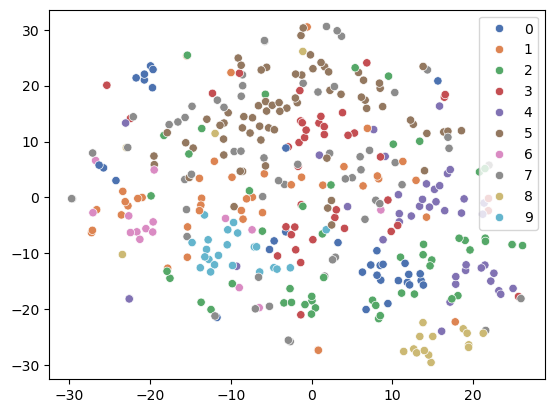

In [84]:

RANDOM_STATE = 2020
# 创建一个TSNE对象，指定要降维到的维数为2，随机数种子为RANDOM_STATE
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, init="random")

# 调用TSNE对象的fit_transform方法，传入X_simple数据集，返回一个降维后的数据数组，赋值给X_tsne
tsne_data = tsne.fit_transform(tfidf_content)

sns.scatterplot(x=tsne_data[:,0], y=tsne_data[:,1], hue=labels, palette="deep") # 散点图